# DATA CLEANING PROCEDURES

---
# 1. Loading the Database

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/submission.csv')
#columns_description = pd.read_csv('column_descriptions.csv')

# Quick overview
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("\nTrain columns and types:\n", train.dtypes.head())
train.head() # Display first few rows of the train dataset

Train shape: (15391, 76)
Test shape: (3848, 75)

Train columns and types:
 Unnamed: 0           int64
id                   int64
short_name          object
long_name           object
player_positions    object
dtype: object


,Unnamed: 0,id,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
0,0,261358,Y. Sylla,Youssuf Sylla,ST,58,76,525000.0,952.712115,18,...,43,13,19,17,7,6,8,10,7,NaN
1,1,252435,J. Austerfield,Josh Austerfield,"CM, CDM",55,75,350000.0,902.232819,19,...,48,40,48,45,14,8,5,14,11,NaN
2,2,248723,C. Malley,Connor Malley,"CAM, CM",53,66,230000.0,2873.818374,21,...,52,26,23,31,14,8,13,9,6,NaN
3,3,251157,Lee Gwang Yeon,이광연 Gwang Yeon Lee,GK,60,71,475000.0,678.608124,21,...,26,8,14,12,60,60,54,63,61,23.0
4,4,205393,J. Baldwin,Jack Baldwin,CB,63,65,475000.0,1911.674228,28,...,67,62,63,62,11,12,6,11,14,NaN


---
# 2. Checking missing values

We define a function which summarizes:
* how many missing values each column has
* what % of data is missing
* only columns with missing values are shown
* results are sorted from worst to best

We check both Train and Test datasets, and merge the results for easy comparison.

                           Missing Values (Train)  % Missing (Train)  \
nation_position                             14786          96.069131   
nation_jersey_number                        14786          96.069131   
club_loaned_from                            14515          94.308362   
player_tags                                 14231          92.463128   
goalkeeping_speed                           13662          88.766162   
player_traits                                7936          51.562602   
dribbling                                    1729          11.233838   
shooting                                     1729          11.233838   
passing                                      1729          11.233838   
physic                                       1729          11.233838   
defending                                    1729          11.233838   
pace                                         1729          11.233838   
release_clause_eur                            934           6.06

<Figure size 1200x600 with 0 Axes>

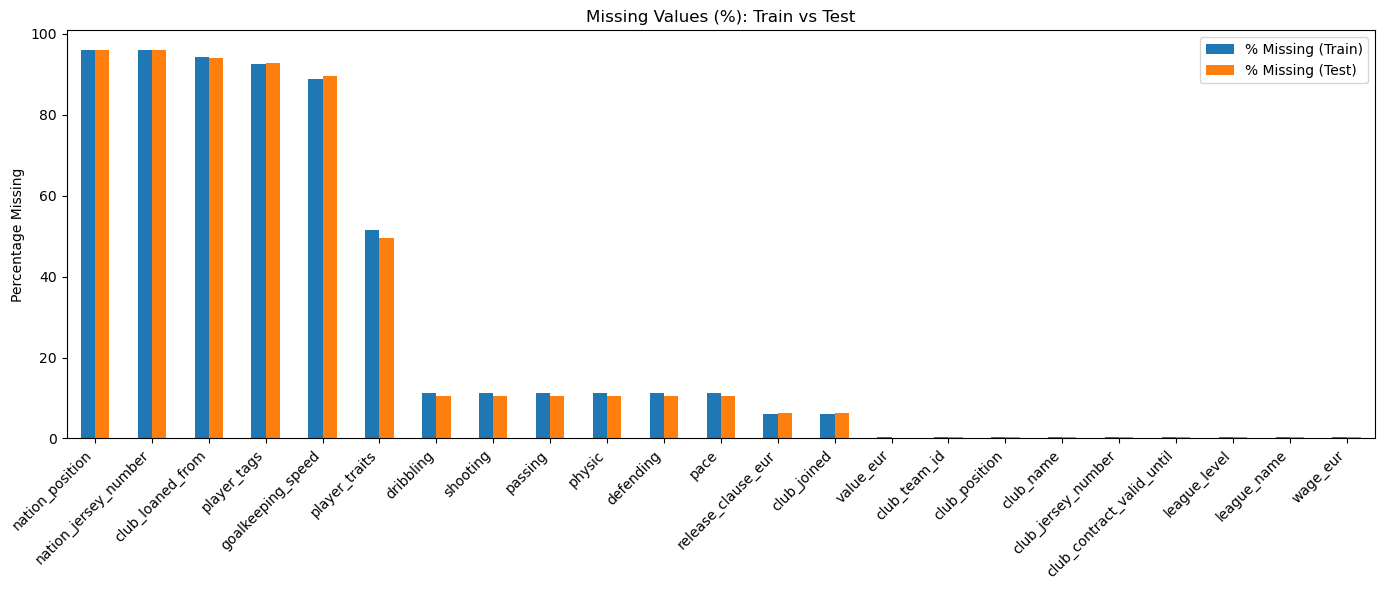

In [3]:
# Function to summarize missing values
def missing_summary(df, dataset_name="Dataset"):
    total = df.isnull().sum()
    percent = (total / len(df)) * 100
    missing_table = pd.concat([total, percent], axis=1)
    missing_table.columns = [f'Missing Values ({dataset_name})', f'% Missing ({dataset_name})']
    missing_table = missing_table[missing_table[f'Missing Values ({dataset_name})'] > 0]
    return missing_table.sort_values(f'% Missing ({dataset_name})', ascending=False)

# Summarizing missing values for train and test
missing_train = missing_summary(train, "Train")
missing_test = missing_summary(test, "Test")

# Merging both summaries together
missing_values = missing_train.merge(missing_test, how='outer', left_index=True, right_index=True)

# Sort by maximum % missing across Train and Test
missing_values['Max % Missing'] = missing_values[
    [col for col in missing_values.columns if '% Missing' in col]
].max(axis=1)
missing_values = missing_values.sort_values(by='Max % Missing', ascending=False)
missing_values.drop(columns='Max % Missing', inplace=True)

# Display the missing values table
print(missing_values)

# Visualizing missing values
plt.figure(figsize=(12, 6))
missing_values[
    [col for col in missing_values.columns if '% Missing' in col]
].plot(kind='bar', figsize=(14, 6))
plt.title("Missing Values (%): Train vs Test")
plt.ylabel("Percentage Missing")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
# 3. Planning the Cleaning Strategy

After analyzing the missing values, we decided cleaning actions based on two criteria:
- percentage of missing values;
- importance of each column for predicting player market value

Actions applied:
* DROP columns with too many missing values (>50%) -> if they are not critical 
* FILL missing values in numerical columns -> using median to avoid influence from outliers
* FILL missing values in categorical columns -> with 'unknown'

In [4]:
# Columns to drop
columns_to_drop = [
    'player_traits', 'player_tags', 'club_loaned_from', 'nation_jersey_number', 
    'nation_position', 'goal_keeping_speed']

# Numerical Columns to Fill with Median
numerical_cols = [
    'release_clause_eur', 'defending', 'dribbling', 'pace',
    'passing', 'physic', 'shooting', 'wage_eur']
# (Exclude club_jersey_number: not relevant)

# Categorical Columns to Fill with 'Unknown'
categorical_cols = [
    'club_name', 'club_position', 'league_name', 'club_contract_valid_until']

---
# 4. Applying the Cleaning

In [5]:
# 1. DROP columns -> too many missing values + not critical for predicting market value
train.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test.drop(columns=columns_to_drop, inplace=True, errors='ignore')
# Quick check : dropped columns
print("Dropped columns from train:", columns_to_drop)
print("Dropped columns from test:", columns_to_drop)

# 2. FILL numerical columns -> with median
for column in numerical_cols: 
    median_value = train[column].median()
    train[column] = train[column].fillna(median_value)
    test[column] = test[column].fillna(median_value)
# Quick check: filled numerical columns
print("Train numerical columns after filling:", train[numerical_cols].isnull().sum())
print("Test numerical columns after filling:", test[numerical_cols].isnull().sum())

# 3. FILL categorical columns -> with 'Unknown'
for column in categorical_cols:
    train[column] = train[column].fillna('Unknown')
    test[column] = test[column].fillna('Unknown')   
# Quick check: filled categorical columns
print("Train categorical columns after filling:", train[categorical_cols].isnull().sum())
print("Test categorical columns after filling:", test[categorical_cols].isnull().sum())

#4. FILL remaining missing values -> with 'Unknown'
train.fillna('Unknown', inplace=True)
test.fillna('Unknown', inplace=True)
# Last check: filled remaining missing values
print("Remaining missing values in train:", train.isnull().sum().sum())
print("Remaining missing values in test:", test.isnull().sum().sum())


Dropped columns from train: ['player_traits', 'player_tags', 'club_loaned_from', 'nation_jersey_number', 'nation_position', 'goal_keeping_speed']
Dropped columns from test: ['player_traits', 'player_tags', 'club_loaned_from', 'nation_jersey_number', 'nation_position', 'goal_keeping_speed']
Train numerical columns after filling: release_clause_eur    0
defending             0
dribbling             0
pace                  0
passing               0
physic                0
shooting              0
wage_eur              0
dtype: int64
Test numerical columns after filling: release_clause_eur    0
defending             0
dribbling             0
pace                  0
passing               0
physic                0
shooting              0
wage_eur              0
dtype: int64
Train categorical columns after filling: club_name                    0
club_position                0
league_name                  0
club_contract_valid_until    0
dtype: int64
Test categorical columns after filling: club

C:\Users\Albin\AppData\Local\Temp\ipykernel_14128\3764203635.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train.fillna('Unknown', inplace=True)
C:\Users\Albin\AppData\Local\Temp\ipykernel_14128\3764203635.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test.fillna('Unknown', inplace=True)


---
# 5. Checking database Consistency

Before training a model, we need to make sure that the train and test datasets have the same structure.

We need to take into account that the train set contains the target column 'value_eur', while the test set does not because we still need to predict it. So we temporarily drop this column from the train set before comparing

In [6]:
train_features = train.drop(columns=['value_eur'])

# Checking if train and test datasets have the same columns
train_columns = set(train_features.columns)
test_columns = set(test.columns)

if train_columns != test_columns:
    print("Mismatch in columns between train and test datasets:")
    print("Columns in train but not in test:", train_columns - test_columns)
    print("Columns in test but not in train:", test_columns - train_columns)
else:
    print("Train and test datasets have the same columns.")


Train and test datasets have the same columns.


---
# 6. Final Checks


In [7]:
# Checking for unexpected missing values
missing_train = train.isnull().sum()[train.isnull().sum() > 0]
if missing_train.empty:
    print("No unexpected missing values in train dataset. ")
else:
    print(missing_train)

missing_test = test.isnull().sum()[test.isnull().sum() > 0]
if missing_test.empty:
    print("No unexpected missing values in test dataset. ")
else:
    print(missing_test)

No unexpected missing values in train dataset. 
No unexpected missing values in test dataset. 


---
# 7. Conclusion
This data cleaning process helped us to make sure that the datasets are consistent and ready for modelling. 

We addressed missing values by dropping irrelevant columns, properly filling missing values , and verifying that the train and test datasets have matching structures. 

With the data now cleaned and organized, we're ready to build and evaluate predictive models.